In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [3]:
# Parámetros de los datos sintéticos
num_samples = 100000  
num_features = 10    

feature_names = [
    'TEM-1', 'TEM-2', 'KPC', 'NDM-1',             # β-Lactamasas
    'AAC6_Ib', 'APH3_Ia', 'ANT2_Ia', 'AAC3_I',  # Enzimas aminoglucósido-modificadoras
    'ACC', 'AME'
]

np.random.seed(42)  
X = np.zeros((num_samples, num_features), dtype=int)

probabilidades = {
    'TEM-1': 0.3,
    'TEM-2': 0.2,
    'KPC': 0.05,
    'NDM-1': 0.03,
    'AAC6_Ib': 0.25,
    'APH3_Ia': 0.2,
    'ANT2_Ia': 0.15,
    'AAC3_I': 0.1,
    'ACC': 0.05,
    'AME': 0.1
}

for i, enzima in enumerate(feature_names):
    X[:, i] = np.random.binomial(1, probabilidades[enzima], num_samples)

# Crear DataFrame
df = pd.DataFrame(X, columns=feature_names)

df['resistencia'] = (
    df[['TEM-1', 'TEM-2', 'KPC', 'NDM-1']].sum(axis=1) >= 1
) | (
    df[['AAC6_Ib', 'APH3_Ia', 'ANT2_Ia', 'AAC3_I', 'ACC', 'AME']].sum(axis=1) >= 1
)
df['resistencia'] = df['resistencia'].astype(int)

# Mostrar las primeras filas del DataFrame
print(df.head())


   TEM-1  TEM-2  KPC  NDM-1  AAC6_Ib  APH3_Ia  ANT2_Ia  AAC3_I  ACC  AME  \
0      0      0    0      0        1        0        0       0    0    0   
1      1      0    0      0        0        0        0       0    0    0   
2      1      0    0      0        0        0        1       0    0    0   
3      0      0    0      0        1        1        0       1    0    0   
4      0      0    0      0        0        0        0       0    0    0   

   resistencia  
0            1  
1            1  
2            1  
3            1  
4            0  


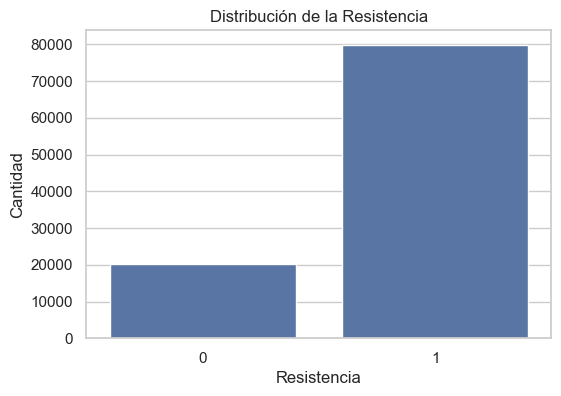

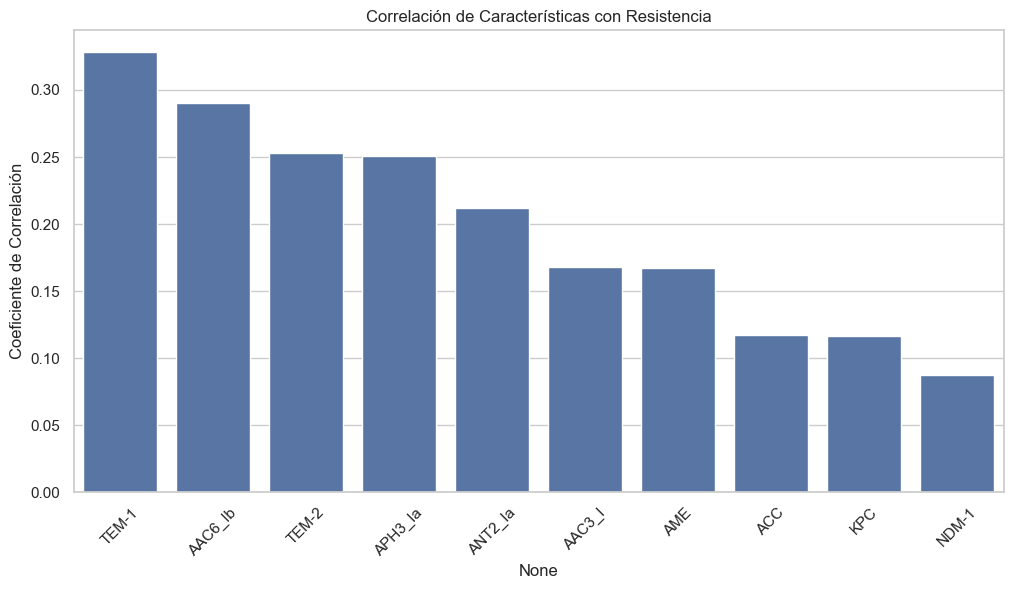

In [4]:
# Distribución de las etiquetas
plt.figure(figsize=(6,4))
sns.countplot(x='resistencia', data=df)
plt.title('Distribución de la Resistencia')
plt.xlabel('Resistencia')
plt.ylabel('Cantidad')
plt.show()

# Correlación entre características y la etiqueta
plt.figure(figsize=(12,6))
corr = df.corr()['resistencia'].drop('resistencia').sort_values(ascending=False)
sns.barplot(x=corr.index, y=corr.values)
plt.xticks(rotation=45)
plt.title('Correlación de Características con Resistencia')
plt.ylabel('Coeficiente de Correlación')
plt.show()


In [5]:
# Separar características y etiquetas
X = df.drop('resistencia', axis=1).values
y = df['resistencia'].values

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalado de características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verificar las dimensiones
print(f'Tamaño de entrenamiento: {X_train.shape}')
print(f'Tamaño de prueba: {X_test.shape}')


Tamaño de entrenamiento: (80000, 10)
Tamaño de prueba: (20000, 10)


In [6]:
model = Sequential()

# Capa de entrada
model.add(Dense(64, input_dim=num_features, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()


c:\Users\JUAN BERNAL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,553 (13.88 KB)

 Non-trainable params: 224 (896.00 B)

In [9]:
# Definir callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8435 - loss: 0.3832 - val_accuracy: 1.0000 - val_loss: 0.0199
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9996 - loss: 0.0272 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 5.9011e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 3.5322e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 2.2823e-04
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.001

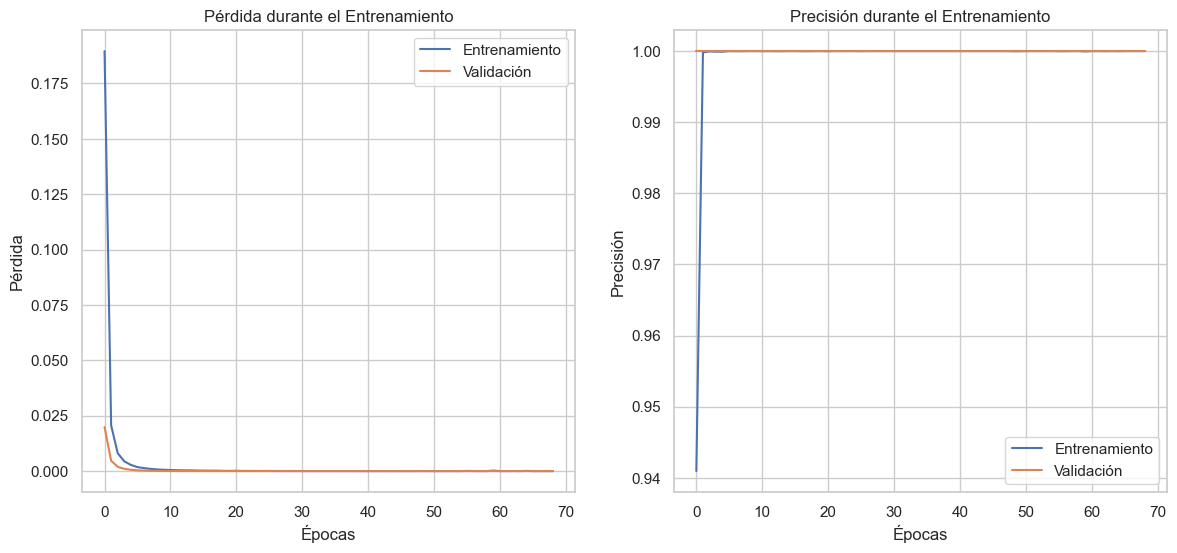

In [11]:
# Gráficas de pérdida y precisión
plt.figure(figsize=(14,6))

# Pérdida
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()
